# Example Inductance Correction

Below is an example of our suggested method of processing EIS data using the functions in "inductance_correction_functions.ipynb". The general steps are as follows:

1. Import the EIS spectrum
2. Remove outliers with LinKK
3. Correct for inductance
4. Remove ohmic resistance
5. Plot the original, LinKK-filtered, and corrected spectra
6. Fit the spectrum with an equivalent circuit to confirm the inductance correction

# Inductance Correction Functions

This code was written for easy EIS data processing in Python. Included below are functions for filtering data via the LinKK test, correcting for inductance (both automatically calculated and known), and removal ohmic resistance (automatically calculated and manual). 

These functions rely on the packages imported below, but particularly the impedance.py package, which is cited here:

Murbach et al., (2020). impedance.py: A Python package for electrochemical impedance analysis. Journal of Open Source Software, 5(52), 2349, https://doi.org/10.21105/joss.02349

In [1]:
import impedance
import csv
import pandas as pd
from impedance.models.circuits import CustomCircuit
import cmath
import numpy as np
import matplotlib.pyplot as plt
from impedance.visualization import plot_nyquist, plot_residuals, plot_bode
from impedance import preprocessing
from impedance.validation import linKK
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


%matplotlib inline

# Functions

## Manual Inductance Correction
This function takes a known impedance and corrects a given EIS spectrum. Inputs include the frequency array, Z array, and the inductance. The function returns the frequency array and corrected complex impedance array.

In [2]:
def correct_known_inductance(f,Z,L):
    Z_real=np.real(Z)
    Z_imaginary=np.imag(Z)
    Z_imaginary_corrected=[]
    l=len(Z_imaginary)
    for i in range(l):
        Z_imaginary_corrected.append(Z_imaginary[i]-L*2*np.pi*f[i])
        
    Z_corrected=[]
    for i in range(l):
        Z_corrected.append(complex(Z_real[i],Z_imaginary_corrected[i]))
    
    return(np.array(f), np.array(Z_corrected))

## Automatic Inductance Correction
The impedance correction automatically corrects for the impedance of your testing system by fitting f vs. Z_imaginary at high frequency. The range of frequencies can be customized as desired. The function takes a frequency array, Z array (which must be complex), and the minimum and maximum frequencies you'd like to fit at. This function returns the frequency array, corrected impedance (complex), and the inductance L.

Typically, inductance is fit to points where f [Hz] > 10^4.

In [3]:
def correct_inductance(f,Z,f_min, f_max):
    data= {'Frequency': f,
        'Z_real': np.real(Z),
        'Z_imaginary' : np.imag(Z)
        }
    df = pd.DataFrame(data)
    df_correction=df[df['Frequency']>f_min]
    linear_model=np.polyfit(df_correction['Frequency'],df_correction['Z_imaginary'],1)
    p = np.poly1d(linear_model)
    x_s=np.arange(f_min,f_max)
    L=linear_model[0]/(2*np.pi)
    
    Z_imaginary=df['Z_imaginary'].to_numpy()
    
    Z_real=np.real(Z)
    Z_imaginary_corrected=[]
    l=len(Z_imaginary)
    for i in range(l):
        Z_imaginary_corrected.append(Z_imaginary[i]-L*2*np.pi*f[i])
        
    Z_corrected=[]
    for i in range(l):
        Z_corrected.append(complex(Z_real[i],Z_imaginary_corrected[i]))
    
    return(np.array(f), np.array(Z_corrected),L , df['Frequency'], df['Z_imaginary'], x_s, p(x_s))

## Ohmic Resistance Correction
remove_ohmic automatically removes ohmic resistance and any points below the X axis. Input f and Z, returns f_trim and Z_trim. 

***Note: ohmic resistance is automatically calculated to be the Z" value of the highest frequency point that has a positive Z' value, and is approximate. For a more exact correction, fit your spectrum with an equivalent circuit and use remove_ohmic_manual.***

In [4]:
def remove_ohmic(f,Z):
    f_trim, Z_trim = preprocessing.ignoreBelowX(f, Z) #removes Z values where Z[im]<0
    Z_trim_r=np.real(Z_trim)
    Z_trim_i=np.imag(Z_trim)
    R_ohmic=Z_trim_r[0]
    for i in range(len(Z_trim_r)):
        Z_trim_r[i]=Z_trim_r[i]-R_ohmic
        
    for i in range(len(Z_trim_r)):
        Z_trim[i]=complex(Z_trim_r[i],Z_trim_i[i])
    
    return(f_trim,Z_trim)

remove_ohmic_manual removes a given ohmic resistance (R here) from the EIS spectrum. This is handy if you have already fit your EIS spectrum with an equivalent circuit and know R_ohmic already.

In [5]:
#manual ohmic resistance correction
def remove_ohmic_manual(f,Z,R):
    f_trim, Z_trim = preprocessing.ignoreBelowX(f, Z) #removes Z values where Z[im]<0
    Z_trim_r=np.real(Z_trim)
    Z_trim_i=np.imag(Z_trim)
    R_ohmic=R
    for i in range(len(Z_trim_r)):
        Z_trim_r[i]=Z_trim_r[i]-R_ohmic
        
    for i in range(len(Z_trim_r)):
        Z_trim[i]=complex(Z_trim_r[i],Z_trim_i[i])
    
    return(f_trim,Z_trim)

## Outlier correction
The "clean_linkk" function removes any data points that deviate more than a certain percentage from the LinKK fit of our EIS data. The function takes frequency data, Z, and p (which is the maximum fractional acceptable error) and removes points that do not meet this threshold. The function then returns the corrected frequency and Z arrays.

In [6]:
def clean_linkk(f,Z,p):
    M, mu, Z_linKK, res_real, res_imag = linKK(f, Z, c=.5, max_M=100, fit_type='complex', add_cap=True)
    data= {'Frequency': f,
        'Z_real': np.real(Z),
        'Z_imaginary' : np.imag(Z),
        'Real Residuals': res_real,
        'Imaginary Residuals': res_imag
        }
    read = pd.DataFrame(data)
    read_filtered=read[abs(read['Real Residuals']<p)&abs(read['Imaginary Residuals']<p)]
    f_f=read_filtered['Frequency'].to_numpy()
    Z_r_f=read_filtered['Z_real'].to_numpy()
    Z_i_f=read_filtered['Z_imaginary'].to_numpy()
    l_f=len(Z_r_f)
    Z_f=np.zeros(l_f,dtype=complex)

    for i in range(l_f):
        Z_f[i]=complex(Z_r_f[i],Z_i_f[i])
        
    return(np.array(f_f), np.array(Z_f))

# Example Inductance Correction with sample data

In [7]:
#Import the impedance data
#There are lots of ways to do this, see the impedance.py documentation to import versaStudio, Parstat data, etc.

electrodeArea=2 #electrode area

f, Z = preprocessing.readCSV('example_3.csv')
Z=Z[:]*electrodeArea
f=f[:]

Text(0.5, 0, 'Z$^\\prime(\\omega)$ [$\\Omega\\cdot cm^2$]')

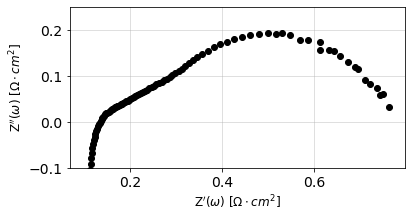

In [8]:
#Plot the data to get the original spectrum
fig, ax = plt.subplots()
#ax.set_aspect(4)
plt.ylim([-0.1,0.25]) #customize this to fit the desired range
plot_nyquist(ax, Z, fmt='ok', label='Data')
plt.ylabel('Z$^{\prime \prime}(\omega)$ [$\Omega\cdot cm^2$]', fontsize=12)
plt.xlabel('Z$^\prime(\omega)$ [$\Omega\cdot cm^2$]', fontsize=12)

In [9]:
#Prep the data for correction by removing points with LinKK error greater than 1%

[f_linKK_filtered, Z_linKK_filtered]=clean_linkk(f,Z,0.01) #removing any points with >1% error

10 0.9985659499478554 0.0030597564445764844
20 0.8163953647315674 0.0028362399130949056


10 0.9985659499478554 0.0030597564445764844
20 0.8163953647315674 0.0028362399130949056


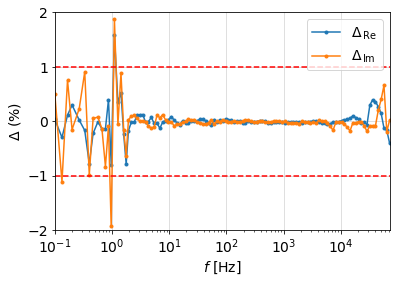

In [10]:
#Plot the LinKK data

fig, ax = plt.subplots()
M, mu, Z_linKK, res_real, res_imag = linKK(f, Z, c=.5, max_M=100, fit_type='complex', add_cap=True)
plot_residuals(ax, f, res_real, res_imag, y_limits=(-2,2))
plt.axhline(y=-1, color='r', linestyle='--')
plt.axhline(y=1, color='r', linestyle='--')

Text(0.5, 0, 'Z$^\\prime(\\omega)$ [$\\Omega\\cdot cm^2$]')

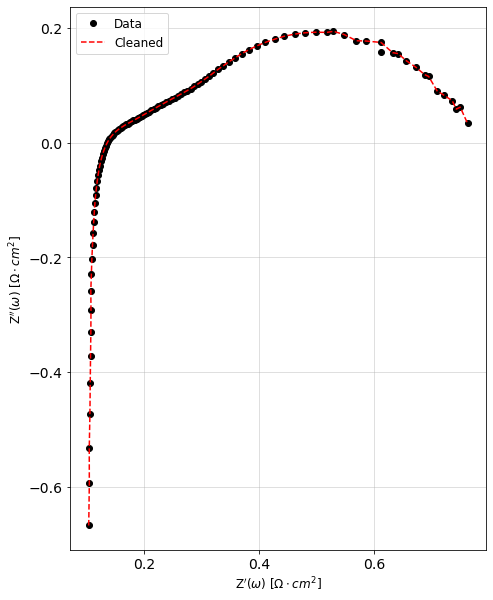

In [11]:
#Plot the cleaned spectrum

fig, ax = plt.subplots(figsize = (12,10))
ax.set_aspect(4)
plot_nyquist(ax, Z, fmt='ok', label='Data')
plot_nyquist(ax, Z_linKK_filtered, fmt='r--', label='Cleaned')
plt.legend(fontsize=12)
plt.ylabel('Z$^{\prime \prime}(\omega)$ [$\Omega\cdot cm^2$]', fontsize=12)
plt.xlabel('Z$^\prime(\omega)$ [$\Omega\cdot cm^2$]', fontsize=12)

In [12]:
#Correct for the inductance
[f_L,Z_L, L, f_fit, Z_fit, x_s, y_s]=correct_inductance(f_linKK_filtered,Z_linKK_filtered,10000,f[0]) #lower limit of 10e4 is taken from Jane's thesis

In [13]:
#Calculated inductance
L

1.543878076473297e-06

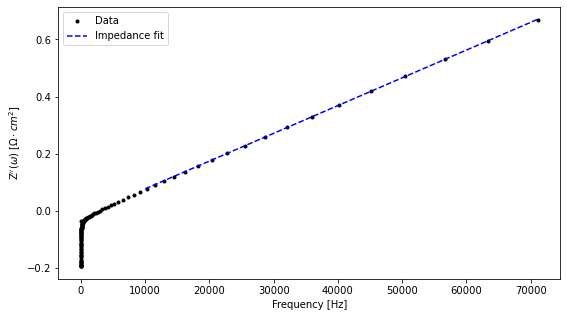

In [14]:
#Show the inductance data fitting

fig1, ax1 = plt.subplots(figsize = (9,5))
plt.plot(f_linKK_filtered, np.imag(Z_linKK_filtered), '.k',label='Data')
plt.plot(x_s, y_s, 'b--',label='Impedance fit')
plt.ylabel('Z$^{\prime \prime}(\omega)$ [$\Omega\cdot cm^2$]')
plt.xlabel('Z$^\prime(\omega) - R_{\Omega}$ [$\Omega\cdot cm^2$]')
plt.xlabel('Frequency [Hz]')
plt.legend()

This looks good! We're fitting to a linear region about 10e4 Hz.

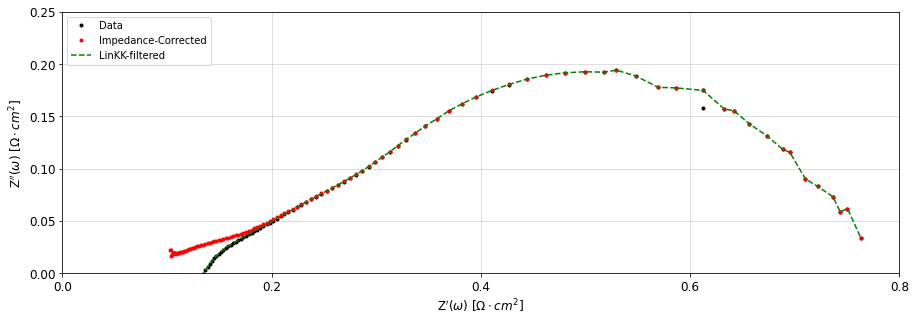

In [16]:
#Plot the original and the corrected data

fig2, ax2 = plt.subplots(figsize = (15,7.5))
plt.ylim([0,0.25])
plt.xlim([0,0.8])
plot_nyquist(ax2, Z, fmt='.k', label='Data')
plot_nyquist(ax2, Z_L, fmt='.r', label='Impedance-Corrected')
plot_nyquist(ax2, Z_linKK_filtered, fmt='g--', label='LinKK-filtered')

plt.ylabel('Z$^{\prime \prime}(\omega)$ [$\Omega\cdot cm^2$]', fontsize=12)
plt.xlabel('Z$^\prime(\omega)$ [$\Omega\cdot cm^2$]', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(loc=2)

Great! We now have the inductance-corrected data which, as expected, has a more prominent high frequency peak than the raw data. Let's now check that the value we calculated for L matches up with what we can calculate from the equivalent circuit model.

From previous work, we know that a good model for this data is an R-L-RQ-RQ circuit

In [17]:
circuit = 'R_0-L0-p(R_1,CPE_1)-p(R_2,CPE_2)' #Define the equivalent circuit
initial_guess = [1.5, 7*10**(-6), .05, 0.5,0.4, 1, 1,0.4] #Provide initial fit guesses

circuit = CustomCircuit(circuit, initial_guess=initial_guess) #creates a circuit to fit using your initial guesses
circuit.fit(f_linKK_filtered, Z_linKK_filtered) #fits the frequencies and Z values you imported

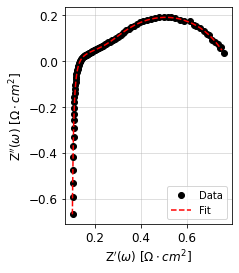

In [19]:
#Plots your data and the fit (Nyquist)
Z_fit = circuit.predict(f_linKK_filtered)
fig, ax = plt.subplots()
plot_nyquist(ax, Z_linKK_filtered, fmt='ko')
plot_nyquist(ax, Z_fit, fmt='r--')

plt.ylabel('Z$^{\prime \prime}(\omega)$ [$\Omega\cdot cm^2$]', fontsize=12)
plt.xlabel('Z$^\prime(\omega)$ [$\Omega\cdot cm^2$]', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(['Data', 'Fit'])
plt.show()

This looks like a good fit for our data. Now we can extract the fitted L value:

In [20]:
print(circuit)


Circuit string: R_0-L0-p(R_1,CPE_1)-p(R_2,CPE_2)
Fit: True

Initial guesses:
    R_0 = 1.50e+00 [Ohm]
     L0 = 7.00e-06 [H]
    R_1 = 5.00e-02 [Ohm]
  CPE_1_0 = 5.00e-01 [Ohm^-1 sec^a]
  CPE_1_1 = 4.00e-01 []
    R_2 = 1.00e+00 [Ohm]
  CPE_2_0 = 1.00e+00 [Ohm^-1 sec^a]
  CPE_2_1 = 4.00e-01 []

Fit parameters:
    R_0 = 8.36e-02  (+/- 1.52e-03) [Ohm]
     L0 = 1.52e-06  (+/- 2.78e-09) [H]
    R_1 = 3.81e-01  (+/- 1.45e-02) [Ohm]
  CPE_1_0 = 3.07e-01  (+/- 3.67e-03) [Ohm^-1 sec^a]
  CPE_1_1 = 8.62e-01  (+/- 1.07e-02) []
    R_2 = 3.35e-01  (+/- 2.17e-02) [Ohm]
  CPE_2_0 = 5.05e-01  (+/- 3.71e-02) [Ohm^-1 sec^a]
  CPE_2_1 = 3.47e-01  (+/- 9.04e-03) []



Above, we calculated that L=1.54e-06, and the equivalent circuit model is giving L=1.52e-06, which is a good match. However, our original calculation didn't rely on any knowledge of the equivalent circuit or initial guesses.